In [1]:
import sys
import logging

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.utils.data import DataLoader

In [5]:
import torchvision
from torchvision import datasets
from torchvision.utils import make_grid

In [6]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)

# Data Load

In [7]:
train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x * 2 - 1), # центрируем для лучшего обучения
    ]),
    download=True,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 238643250.91it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 80328709.43it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 111143292.83it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24175797.93it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [8]:
test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x * 2 - 1), # центрируем для лучшего обучения
    ]),
    download=False,
)

In [9]:
len(train_dataset), len(test_dataset)

(60000, 10000)

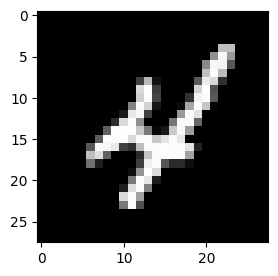

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(train_dataset[9][0].detach().cpu().numpy()[0], cmap='gray')

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
for batch in train_loader:
    data, labels = batch
    print(data.shape)
    print(labels.shape)
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64, 1, 28, 28])
torch.Size([64])


# Model

In [13]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: int,
    ):
        super(ConvBlock, self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=padding,
            ),
#             nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer(x)

In [14]:
class ConvTransposeBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: int,
    ):
        super(ConvTransposeBlock, self).__init__()

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=padding,
            ),
#             nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer(x)

In [15]:
class ConvVAE(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # q(z|x)
        self.encoder = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=32, kernel_size=3, padding=0),
            ConvBlock(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            ConvBlock(in_channels=64, out_channels=128, kernel_size=3, padding=0),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0),
        )
        self.to_latent_fc = nn.Linear(256 * 20 * 20, 2 * latent_dim)

        # p(x|z)
        self.decoder = nn.Sequential(
            ConvTransposeBlock(in_channels=256, out_channels=128, kernel_size=3, padding=0),
            ConvTransposeBlock(in_channels=128, out_channels=64, kernel_size=3, padding=0),
            ConvTransposeBlock(in_channels=64, out_channels=32, kernel_size=3, padding=0),
            nn.ConvTranspose2d(in_channels=32, out_channels=in_channels, kernel_size=3, padding=0),
        )
        self.from_latent_fc = nn.Linear(latent_dim, 256 * 20 * 20)

    def encode(self, x) -> tuple:
        out = self.encoder(x)
        flatten = torch.flatten(out, start_dim=1)
        latent = self.to_latent_fc(flatten)

        mu, log_sigma = latent[:, :self.latent_dim], latent[:, self.latent_dim:]
        return mu, log_sigma

    def decode(self, x):
        img = self.from_latent_fc(x).reshape(-1, 256, 20, 20)
        return self.decoder(img)

    def gaussian_sampler(self, mu, log_sigma):
        std = log_sigma.exp()
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, log_sigma = self.encode(x)
        sample = self.gaussian_sampler(mu, log_sigma)
        return mu, log_sigma, self.decode(sample)

In [16]:
def count_parameters(model: nn.Module):
    """Количество обучаемых параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
model = ConvVAE(1, 32)

In [18]:
a, b = model.encode(data)#.chunk(2, 1)
a.shape, b.shape

(torch.Size([64, 32]), torch.Size([64, 32]))

In [19]:
sample = model.gaussian_sampler(a, b)
sample.shape

torch.Size([64, 32])

In [20]:
model.decode(sample).shape

torch.Size([64, 1, 28, 28])

In [21]:
mu, log_sigma, out = model(data)
mu.shape, log_sigma.shape, out.shape

(torch.Size([64, 32]), torch.Size([64, 32]), torch.Size([64, 1, 28, 28]))

In [22]:
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 10,708,289 trainable parameters


In [23]:
model.encode(data)

(tensor([[ 0.0039,  0.0446,  0.0079,  ..., -0.0097, -0.0366,  0.0076],
         [-0.0112,  0.0382, -0.0089,  ..., -0.0025, -0.0637,  0.0091],
         [ 0.0120,  0.0473, -0.0004,  ..., -0.0351, -0.0358,  0.0095],
         ...,
         [ 0.0044,  0.0289, -0.0068,  ..., -0.0180, -0.0651,  0.0247],
         [-0.0050,  0.0375,  0.0076,  ..., -0.0116, -0.0507, -0.0010],
         [ 0.0086,  0.0622,  0.0010,  ..., -0.0057, -0.0576,  0.0048]],
        grad_fn=<SliceBackward0>),
 tensor([[ 0.0059,  0.0201, -0.0231,  ..., -0.0100, -0.0053, -0.0018],
         [ 0.0081,  0.0121, -0.0069,  ...,  0.0172, -0.0113, -0.0016],
         [ 0.0279,  0.0191, -0.0155,  ..., -0.0062, -0.0061, -0.0093],
         ...,
         [ 0.0184,  0.0205, -0.0072,  ..., -0.0179, -0.0228,  0.0069],
         [ 0.0392,  0.0191, -0.0095,  ...,  0.0035, -0.0078, -0.0239],
         [ 0.0263,  0.0101, -0.0164,  ...,  0.0161, -0.0091, -0.0111]],
        grad_fn=<SliceBackward0>))

# Loss

Распишем правдоподобие как сумму вариационной нижней оценки (ELBO) и KL-дивергенции от вариационного распределения и апостериорного распределения:
### $$
    \log p(\mathbf{x} | \boldsymbol{\theta}) = \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) + KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}))
$$

ELBO расписывается в виде:
### $$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$

Для расчета функции потерь определим:
- $\log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$, генеративное распределение из $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
- KL-дивергенция между $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$ и стандартным нормальным $\mathcal{N}(0, I)$.


Вместо максимизации логарифма правдоподобия мы будем максимизировать ELBO. Так как оптимизаторы в pytorch минимизируют ошибку, не забудем поменять знаки в $ \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) $

In [24]:
def neg_log_likelihood(x, mu, log_sigma):
    dist = torch.distributions.Normal(mu.float(), log_sigma.exp().float())
    return - dist.log_prob(x)

In [25]:
def KL_divergence(q_mu, q_log_sigma, p_mu, p_log_sigma):
    q_std = torch.exp(q_log_sigma).float()
    p_std = torch.exp(p_log_sigma).float()

    q = torch.distributions.Normal(q_mu.float(), q_std)
    p = torch.distributions.Normal(p_mu.float(), p_std)

    return torch.distributions.kl_divergence(q, p)

In [26]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, target, mu_x, log_sigma_x, mu_z, log_sigma_z, beta: float = 1.0):
        """
        :param target: вход для сети
        :param mu_x: матожидание декодера p(x|z)
        :param log_sigma_x: логарифм сигмы декодера p(x|z)
        :param mu_z: матожидание энкодера q(z|x)
        :param log_sigma_z: логарифм сигмы энкодера q(z|x)
        :param beta: KL annealing parameter (против коллапса апостериорного распр-я)
        """
        reconstraction_loss = neg_log_likelihood(target, mu_x, log_sigma_x).sum()
        kl_loss = KL_divergence(
            mu_z,
            log_sigma_z,
            torch.zeros_like(mu_z),
            torch.zeros_like(log_sigma_z)
        ).sum()
        # KL annealing (против коллапса апостериорного распр-я)
        return reconstraction_loss + beta * kl_loss

In [27]:
neg_log_likelihood(data, out, torch.zeros_like(data)).sum((1, 2, 3)).sum()

tensor(71076.4609, grad_fn=<SumBackward0>)

In [28]:
neg_log_likelihood(data, out, torch.zeros_like(data)).sum()

tensor(71076.4531, grad_fn=<SumBackward0>)

In [29]:
KL_divergence(mu, log_sigma, torch.zeros_like(mu), torch.zeros_like(log_sigma)).sum()

tensor(1.8638, grad_fn=<SumBackward0>)

In [30]:
KL_divergence(mu, log_sigma, torch.zeros_like(mu), torch.zeros_like(log_sigma)).sum(1).sum()

tensor(1.8638, grad_fn=<SumBackward0>)

# Train

In [31]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    clip: float = 3.0,
    train_history=None,
    valid_history=None,
    beta: float = 1.0,
):
    epoch_loss = 0
    history = []

    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        data = batch[0].to(device)
        labels = batch[1].to(device)

        mu_z, log_sigma_z, output = model(data)

        loss = criterion(
            target=data,
            mu_x=output,
            log_sigma_x=torch.zeros_like(data),
            mu_z=mu_z,
            log_sigma_z=log_sigma_z,
            beta=beta,
        )
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        history.append(loss.cpu().data.numpy())
        if ((i + 1) % 10 == 0) or (i == (len(train_loader) - 1)):
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

            clear_output(True)
            ax[0].plot(np.log1p(history), label="train loss")
            ax[0].set_xlabel("Batch")
            ax[0].set_title("Train loss")
            if train_history is not None:
                ax[1].plot(train_history, label="general train history")
                ax[1].set_xlabel("Epoch")
            if valid_history is not None:
                ax[1].plot(valid_history, label="general valid history")
            plt.legend()

            plt.show()
        i += 1

    return epoch_loss / len(train_loader), loss

In [32]:
def validate(
    model: nn.Module, valid_loader: DataLoader, criterion: nn.Module, device: str
):

    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            data = batch[0].to(device)
            labels = batch[1].to(device)

            mu_z, log_sigma_z, output = model(data)
            loss = criterion(
                target=data,
                mu_x=output,
                log_sigma_x=torch.zeros_like(data),
                mu_z=mu_z,
                log_sigma_z=log_sigma_z,
                beta=1.0,
            )
            epoch_loss += loss.item()

    return epoch_loss / len(valid_loader)

In [33]:
def fit(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    criterion,
    optimizer,
    start_epoch: int,
    end_epoch: int,
    clip: float = 3.0,
):

    train_losses = []
    valid_losses = []

    beta: float = 0.0

    for epoch in range(start_epoch, end_epoch):
        train_loss, last_batch_loss = train(
            model,
            train_loader,
            criterion,
            optimizer,
            device,
            clip,
            train_losses,
            valid_losses,
            beta,
        )
        valid_loss = validate(model, valid_loader, criterion, device)
        logging.info(
            f"Epoch: {epoch}, Training Loss: {train_loss}, Valid Loss: {valid_loss}"
        )

        beta = min(beta + 0.2, 1.0)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    return train_losses, valid_losses

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [35]:
model = ConvVAE(1, 32)
model.to(device)
print()

In [36]:
start_epoch = 0
end_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)
criterion = VAELoss()

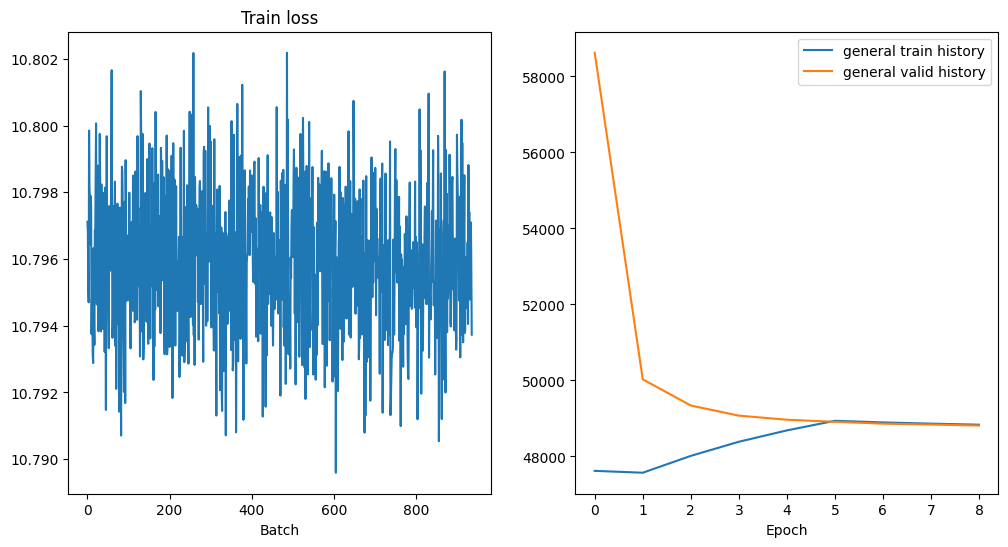

100%|██████████| 156/156 [00:02<00:00, 62.54it/s]


In [37]:
train_losses, valid_losses = fit(
    model=model,
    train_loader=train_loader,
    valid_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
)

In [38]:
def sample(n, device='cpu'):
    with torch.no_grad():
        z = torch.randn(n, model.latent_dim).to(device)
        out = model.decode(z)
        samples = torch.clamp(out, -1, 1)
    return samples.cpu().numpy() * 0.5 + 0.5  # центрируем обратно

In [39]:
def show_samples(samples, title, figsize=None, nrow=None):
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow, pad_value=1, padding=1)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()

In [40]:
samples = sample(25, device)

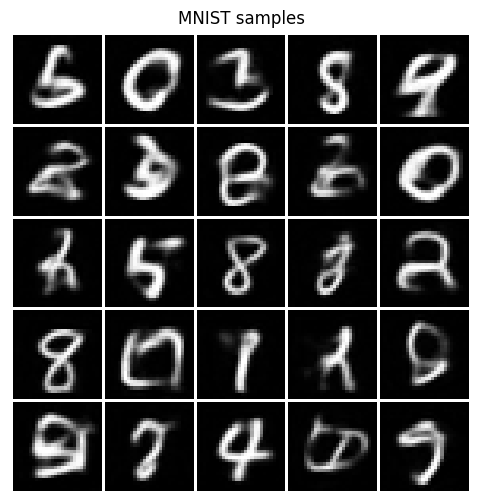

In [41]:
show_samples(samples, title='MNIST samples', nrow=5)